In [19]:
# Importamos todas las librerías que necesitaremos
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [20]:
df_modelo = pd.read_csv('df_eda_limpio.csv')
df_modelo.head()

,make,model,version,fuel,year,kms,power,shift,price,dealer_name,...,province,vehicle_age,price_per_power,price_per_year,dealer_info,power_per_kms,make_popularity,model_popularity,big_city_dealer,price_range
0,Opel,Crossland,1.2 GAS 110 GS Line 5p S/S,Gasolina,2022,5.0,110.0,manual,22900,Sergio Y.,...,Barcelona,3,208.19,7633.34,"Sergio Y.\r\n2, Carrer de Jacint Benavente, Po...",22.000000,4591,158,0,20-30k
1,Opel,Crossland,1.2 81kW (110CV) GS Line,Gasolina,2022,24847.0,110.0,manual,19990,Peugeot Alcala 534,...,Madrid,3,181.73,6663.34,"Peugeot Alcala 534\r\nAvenida de José Gárate, ...",0.004427,4591,158,0,10-20k
2,Opel,Crossland,1.5D 88kW (120CV) Business Elegance Auto,Diésel,2021,41356.0,120.0,automatic,18590,Clicars S.,...,Madrid,4,154.92,4647.50,"Clicars S.\r\nSan Cristóbal, Avenida de Andalu...",0.002902,4591,158,1,10-20k
3,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar S.,...,Barcelona,3,206.37,7566.67,"Vallescar S.\r\nParc de Bombers de Sabadell, 5...",10.000000,4591,158,0,20-30k
4,Opel,Crossland,GS-Line 1.2 GAS MT6 S/S 110cv,Gasolina,2022,11.0,110.0,manual,22700,Vallescar Ocasion M.,...,Barcelona,3,206.37,7566.67,"Vallescar Ocasion M.\r\n27, Carrer de Fèlix Fe...",10.000000,4591,158,0,20-30k


In [21]:
# Características originales
features = ['year', 'kms', 'power', 'vehicle_age', 'fuel', 'shift', 'make', 'model']
target = 'price'

# Separamos en variables originales
X = df_modelo[features].copy()
y = df_modelo[target]

In [22]:
# Creamos nuevas características que pueden aportar valor al modelo
# Potencia relativa a la edad (los coches potentes pierden valor más rápido con la edad)
X['power_per_age'] = df_modelo['power'] / (df_modelo['vehicle_age'] + 1)

# Kilometraje anual (un indicador importante del uso del vehículo)
X['km_per_year'] = df_modelo['kms'] / (df_modelo['vehicle_age'] + 1)

# Transformación logarítmica de kilometraje (suaviza valores extremos)
X['log_kms'] = np.log1p(df_modelo['kms'])

# Mostramos las primeras filas de nuestro dataset mejorado
X.head()

,year,kms,power,vehicle_age,fuel,shift,make,model,power_per_age,km_per_year,log_kms
0,2022,5.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,1.25,1.791759
1,2022,24847.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,6211.75,10.120533
2,2021,41356.0,120.0,4,Diésel,automatic,Opel,Crossland,24.0,8271.20,10.629997
3,2022,11.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,2.75,2.484907
4,2022,11.0,110.0,3,Gasolina,manual,Opel,Crossland,27.5,2.75,2.484907


In [23]:
# Definimos cuáles son las características numéricas, incluyendo las nuevas
numeric_features = ['year', 'kms', 'power', 'vehicle_age']
numeric_features_extended = numeric_features + ['power_per_age', 'km_per_year', 'log_kms']
categorical_features = ['fuel', 'shift', 'make', 'model']

# Detectamos outliers mediante Z-score
# Calculamos los Z-scores para características numéricas
z_scores = stats.zscore(X[numeric_features_extended])
abs_z_scores = np.abs(z_scores)

# Consideramos outliers valores con Z-score > 3 (muy alejados de la media)
filtered_entries = (abs_z_scores < 3).all(axis=1)

# Filtramos el dataset para eliminar los outliers
X_filtered = X[filtered_entries]
y_filtered = y[filtered_entries]

# Comprobamos cuántos registros se eliminaron
print(f"Registros originales: {len(X)}")
print(f"Registros después de eliminar outliers: {len(X_filtered)}")
print(f"Registros eliminados: {len(X) - len(X_filtered)} ({(len(X) - len(X_filtered))/len(X)*100:.2f}%)")

Registros originales: 91040
Registros después de eliminar outliers: 86774
Registros eliminados: 4266 (4.69%)


In [24]:
# Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

# Verificamos las dimensiones de los conjuntos
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (69419, 11)
X_test shape: (17355, 11)
y_train shape: (69419,)
y_test shape: (17355,)


In [38]:
# Definimos el preprocesador para las características numéricas y categóricas
preprocessor = ColumnTransformer(
    transformers=[
        # Estandarizamos variables numéricas (media 0, desviación 1)
        ('num', StandardScaler(), numeric_features_extended),
        # Codificamos variables categóricas con one-hot encoding
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Este preprocesador se aplicará de forma automática en el pipeline

In [39]:
# Definimos varios modelos avanzados con configuraciones iniciales
# RandomForest con mayor número de árboles
rf_model = RandomForestRegressor(
    n_estimators=300,  # Más árboles para mejor generalización
    max_depth=None,    # Permitimos árboles profundos
    min_samples_split=2,
    random_state=42
)

In [40]:
# XGBoost con regularización para evitar sobreajuste
xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,  # Tasa de aprendizaje baja para mejor generalización
    max_depth=6,         # Profundidad controlada
    reg_lambda=1.0,      # Regularización L2
    random_state=42
)

In [41]:
# Actualizamos el diccionario de modelos
models = {
    'RandomForest': rf_model,
    'XGBoost': xgb_model
}

In [43]:
# Configuramos la validación cruzada con 5 folds
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Para cada modelo, ejecutamos validación cruzada y guardamos los resultados
for name, model in models.items():
    print(f"Entrenando modelo: {name}")
    
    # Creamos un pipeline que incluye preprocesamiento y modelo
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Almacenamos los scores de cada fold
    scores = []
    
    # Realizamos la validación cruzada
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_train)):
        # Separamos los datos para este fold
        X_train_cv, X_val_cv = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_cv, y_val_cv = y_train.iloc[train_idx], y_train.iloc[test_idx]
        
        # Entrenamos el pipeline
        pipeline.fit(X_train_cv, y_train_cv)
        
        # Evaluamos en el conjunto de validación
        y_pred_cv = pipeline.predict(X_val_cv)
        fold_score = r2_score(y_val_cv, y_pred_cv)
        scores.append(fold_score)
        
        print(f"  Fold {fold+1}: R² = {fold_score:.4f}")
    
    # Calculamos estadísticas de los scores
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    
    print(f"  Media R²: {mean_score:.4f} (±{std_score:.4f})")
    
    # Entrenamos el modelo con todos los datos de entrenamiento
    pipeline.fit(X_train, y_train)
    
    # Guardamos los resultados
    cv_results[name] = {
        'mean_r2': mean_score,
        'std_r2': std_score,
        'pipeline': pipeline
    }
    
    print("-" * 50)

Entrenando modelo: RandomForest
  Fold 1: R² = 0.9677
  Fold 2: R² = 0.9705
  Fold 3: R² = 0.9696
  Fold 4: R² = 0.9746
  Fold 5: R² = 0.9748
  Media R²: 0.9715 (±0.0028)
--------------------------------------------------
Entrenando modelo: XGBoost
  Fold 1: R² = 0.8800
  Fold 2: R² = 0.8819
  Fold 3: R² = 0.8781
  Fold 4: R² = 0.8864
  Fold 5: R² = 0.8869
  Media R²: 0.8827 (±0.0035)
--------------------------------------------------


In [44]:
# Evaluamos cada modelo individualmente en el conjunto de prueba
individual_results = {}

for name, result in cv_results.items():
    pipeline = result['pipeline']
    y_pred = pipeline.predict(X_test)
    
    # Calculamos métricas de rendimiento
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    individual_results[name] = {
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': y_pred
    }
    
    print(f"Resultados para {name}:")
    print(f"  RMSE: {rmse:.2f} €")
    print(f"  MAE: {mae:.2f} €")
    print(f"  MAPE: {mape:.4f} %")
    print(f"  R²: {r2:.4f}")
    print("-" * 50)

Resultados para RandomForest:
  RMSE: 1311.00 €
  MAE: 296.46 €
  MAPE: 0.2045 %
  R²: 0.9791
--------------------------------------------------
Resultados para XGBoost:
  RMSE: 3033.75 €
  MAE: 1911.77 €
  MAPE: 1.0285 %
  R²: 0.8879
--------------------------------------------------


In [45]:
# Creamos un ensemble ponderado basado en el rendimiento en validación cruzada
predictions = {}
weights = {}
total_weight = 0

# Calculamos los pesos basados en el R² de la validación cruzada
for name, result in cv_results.items():
    # Obtenemos las predicciones del modelo para el conjunto de prueba
    predictions[name] = individual_results[name]['predictions']
    
    # Asignamos peso proporcional al R² (mejor rendimiento = mayor peso)
    weights[name] = result['mean_r2']
    total_weight += weights[name]

# Normalizamos los pesos para que sumen 1
for name in weights:
    weights[name] = weights[name] / total_weight
    print(f"Peso asignado a {name}: {weights[name]:.4f}")

# Calculamos la predicción ponderada
weighted_pred = np.zeros_like(y_test, dtype=float)
for name, pred in predictions.items():
    weighted_pred += weights[name] * pred

Peso asignado a RandomForest: 0.5239
Peso asignado a XGBoost: 0.4761


In [46]:
# Evaluamos el rendimiento del ensemble ponderado
final_rmse = np.sqrt(mean_squared_error(y_test, weighted_pred))
final_mae = mean_absolute_error(y_test, weighted_pred)
final_mape = mean_absolute_percentage_error(y_test, weighted_pred)
final_r2 = r2_score(y_test, weighted_pred)

print("Resultados del Ensemble Ponderado:")
print(f"RMSE final: {final_rmse:.2f} €")
print(f"MAE final: {final_mae:.2f} €")
print(f"MAPE final: {final_mape:.4f} %")
print(f"R² final: {final_r2:.6f}")

# Comparamos con tu mejor modelo anterior
print("\nComparación con el mejor modelo anterior:")
print(f"R² anterior: 0.9785444932042743")
print(f"R² nuevo ensemble: {final_r2:.6f}")
print(f"Mejora absoluta: {final_r2 - 0.9785444932042743:.6f}")
print(f"Mejora relativa: {(final_r2 - 0.9785444932042743) / 0.9785444932042743 * 100:.4f}%")

Resultados del Ensemble Ponderado:
RMSE final: 1867.78 €
MAE final: 1044.14 €
MAPE final: 0.5946 %
R² final: 0.957497

Comparación con el mejor modelo anterior:
R² anterior: 0.9785444932042743
R² nuevo ensemble: 0.957497
Mejora absoluta: -0.021048
Mejora relativa: -2.1509%


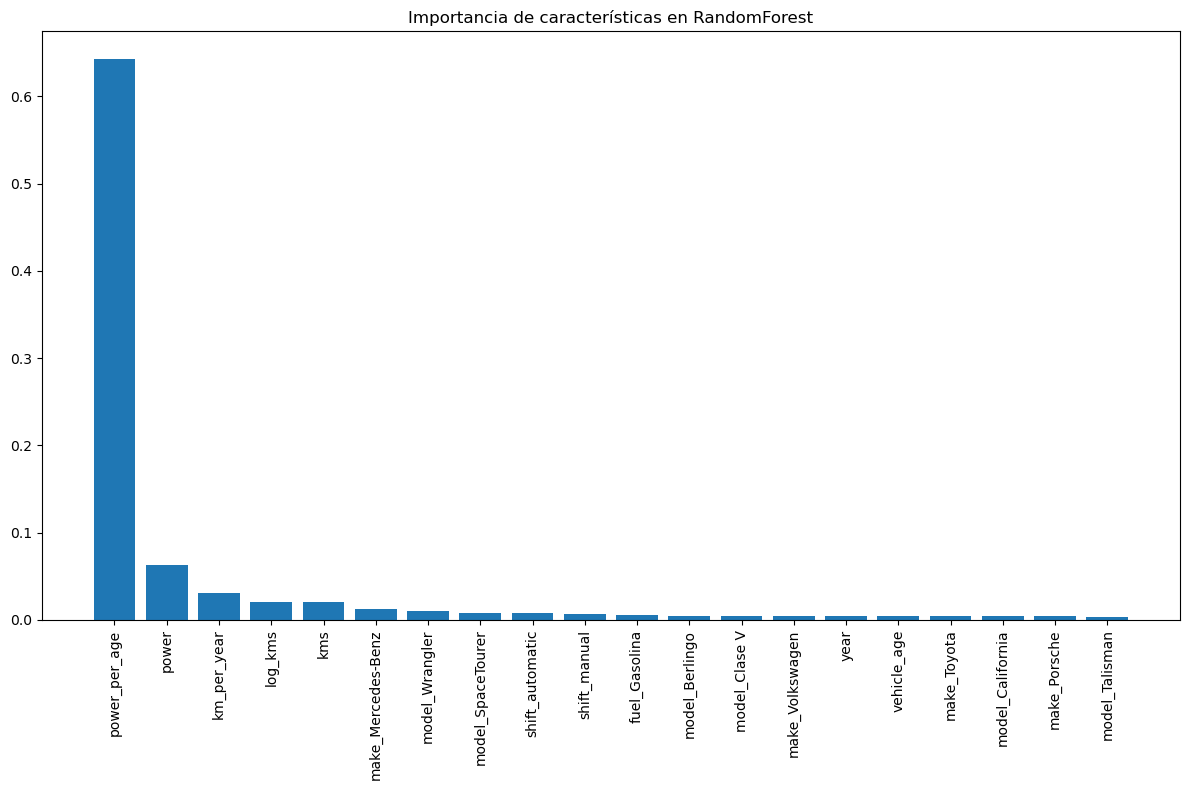

Las 10 características más importantes:
1. power_per_age: 0.6426
2. power: 0.0632
3. km_per_year: 0.0312
4. log_kms: 0.0209
5. kms: 0.0209
6. make_Mercedes-Benz: 0.0129
7. model_Wrangler: 0.0096
8. model_SpaceTourer: 0.0081
9. shift_automatic: 0.0073
10. shift_manual: 0.0067


In [47]:
# Extraemos la importancia de características del modelo RandomForest
rf_pipeline = cv_results['RandomForest']['pipeline']
rf_model = rf_pipeline.named_steps['model']

# Obtenemos los nombres de las características después del procesamiento
feature_names = (
    numeric_features_extended + 
    list(rf_pipeline.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(categorical_features))
)

# Obtenemos los valores de importancia
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Visualizamos las 20 características más importantes
plt.figure(figsize=(12, 8))
plt.title('Importancia de características en RandomForest')
plt.bar(range(min(20, len(importances))), importances[indices[:20]])
plt.xticks(range(min(20, len(importances))), [feature_names[i] for i in indices[:20]], rotation=90)
plt.tight_layout()
plt.show()

# Imprimimos las 10 características más importantes
print("Las 10 características más importantes:")
for i in range(10):
    print(f"{i+1}. {feature_names[indices[i]]}: {importances[indices[i]]:.4f}")

Los 10 casos con mayor error absoluto:
       true_price  predicted_price         error  error_percentage
36680         470     32995.601321  32525.601321       6920.340707
36679         470     32995.601321  32525.601321       6920.340707
23868       44999     19355.182354  25643.817646         56.987528
23869       44999     19355.182354  25643.817646         56.987528
65581         570     21943.060303  21373.060303       3749.659702
46420         374     20012.269429  19638.269429       5250.874179
38829         652     20012.269429  19360.269429       2969.366477
24893         737     19670.186329  18933.186329       2568.953369
32717         737     19670.186329  18933.186329       2568.953369
24896         742     19670.186329  18928.186329       2550.968508

Los 10 casos con mayor error porcentual:
       true_price  predicted_price         error  error_percentage
29301          20      3936.382904   3916.382904      19581.914521
29303          20      3936.382904   3916.382904

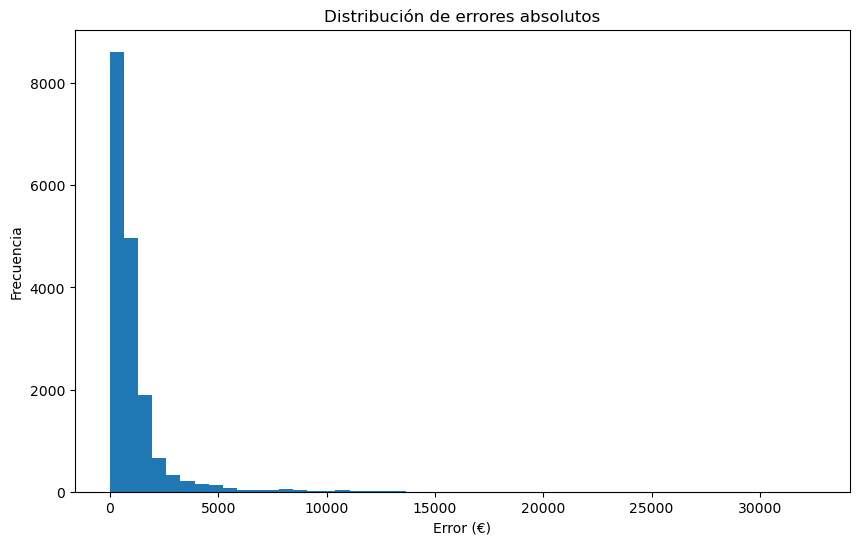

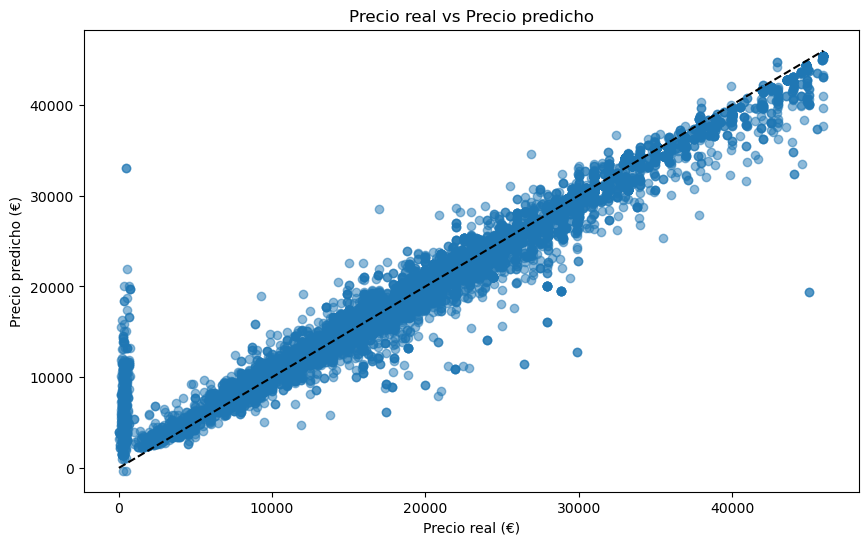

In [48]:
# Analizamos en qué casos el modelo tiene mayor error
errors = np.abs(y_test - weighted_pred)
error_df = pd.DataFrame({
    'true_price': y_test,
    'predicted_price': weighted_pred,
    'error': errors,
    'error_percentage': errors / y_test * 100
})

# Ordenamos por error absoluto
print("Los 10 casos con mayor error absoluto:")
print(error_df.sort_values('error', ascending=False).head(10))

# Ordenamos por error porcentual
print("\nLos 10 casos con mayor error porcentual:")
print(error_df.sort_values('error_percentage', ascending=False).head(10))

# Visualizamos la distribución de errores
plt.figure(figsize=(10, 6))
plt.hist(error_df['error'], bins=50)
plt.title('Distribución de errores absolutos')
plt.xlabel('Error (€)')
plt.ylabel('Frecuencia')
plt.show()

# Visualizamos precio real vs predicción
plt.figure(figsize=(10, 6))
plt.scatter(y_test, weighted_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title('Precio real vs Precio predicho')
plt.xlabel('Precio real (€)')
plt.ylabel('Precio predicho (€)')
plt.show()

In [ ]:
# Guardamos el modelo ensemble para uso futuro
import pickle

# Creamos un diccionario con todos los elementos necesarios para realizar predicciones
model_package = {
    'individual_models': cv_results,
    'weights': weights,
    'preprocessor': preprocessor,
    'numeric_features_extended': numeric_features_extended,
    'categorical_features': categorical_features
}

# Guardamos el paquete completo
with open('modelo_coches_ensemble.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Modelo guardado como 'modelo_coches_ensemble.pkl'")